_Diabetes Data_ from Efron et al. (2004)

Exported from R package `lars`.  
n = 442 patients, with p = 10 predictor variables.

In [30]:
import numpy as np
import seaborn

In [142]:
diabetes = np.loadtxt(fname="diabetes.csv",
                      delimiter=",",
                      skiprows=1,
                      usecols=tuple(range(1,12)),
                      unpack=True, 
                      dtype=None)

In [143]:
X, y = diabetes[:-1,:].T, diabetes[-1]

Now that we have the data, let's observe quickly the marginal scatterplots :

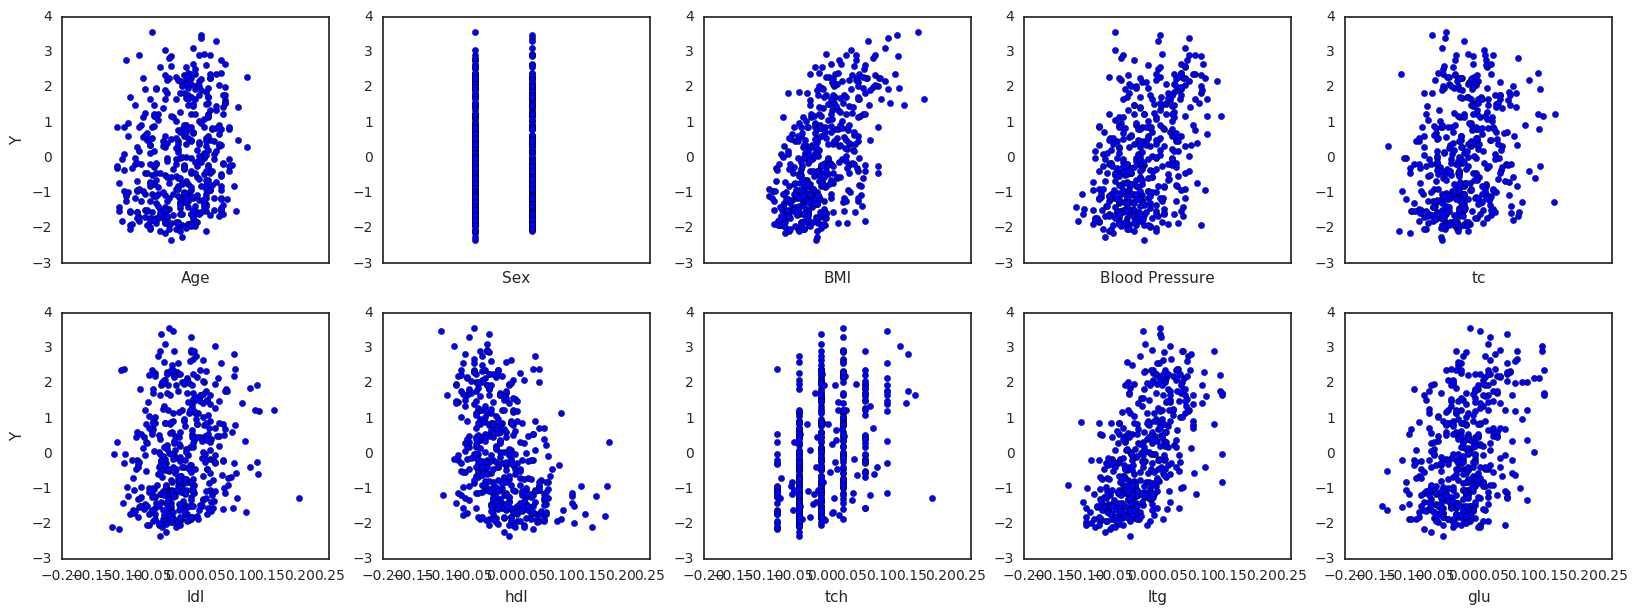

In [144]:
import matplotlib.pyplot as plt

%matplotlib inline

fig, axes = plt.subplots(2, 5, sharex=True, figsize=(20,7))

#predictor variables names
names = ['Age', 'Sex', 'BMI', 'Blood Pressure', 'tc', 'ldl', 'hdl',
         'tch', 'ltg', 'glu']

for i in range(2):
    for j in range(5):
        k = 5*i + j
        axes[i,j].scatter(X[:,k], y)
        axes[i,j].set_xlabel(names[k]);
axes[0,0].set_ylabel('Y'); axes[1,0].set_ylabel('Y'); 

In [145]:
from pymc3 import Model, Normal, Laplace

In [146]:
import theano
import theano.tensor as T
floatX = theano.config.floatX

X = X.astype(floatX)
y = y.astype(floatX)

In [7]:
import pymc3.math as pmm
laplace_model = Model()

_lambda = 0.37

with laplace_model:
    
    # Prior for alpha
    alpha = Laplace('alpha', b = 1/_lambda, mu=0, shape=10)
    
    mu = T.dot(X,alpha)
    
    y_obs = Normal('Y_obs', mu=mu, sd=1, observed=y)

In [8]:
from pymc3 import NUTS, sample
from scipy import optimize

with laplace_model:
    
    trace = sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -645.15: 100%|██████████| 200000/200000 [00:19<00:00, 10504.22it/s]
Finished [100%]: Average ELBO = -645.14
100%|██████████| 10000/10000 [00:18<00:00, 552.86it/s]


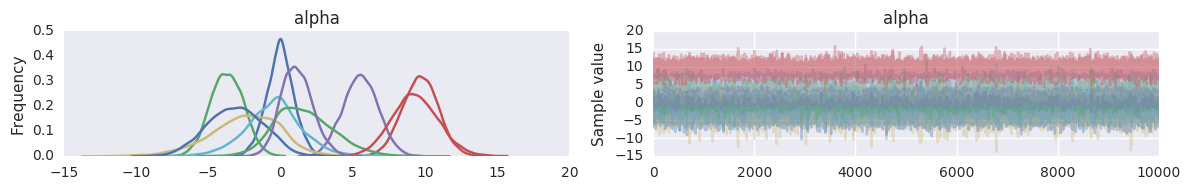

In [32]:
from pymc3 import traceplot

traceplot(trace);

In [10]:
from pymc3 import summary

summary(trace)


alpha:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  -0.038           0.937            0.009            [-1.797, 1.951]
  -3.699           1.138            0.011            [-5.943, -1.511]
  9.661            1.223            0.012            [7.352, 12.154]
  5.546            1.207            0.012            [3.102, 7.821]
  -2.485           2.459            0.051            [-7.583, 1.966]
  -0.450           2.010            0.041            [-4.697, 3.340]
  -3.106           1.922            0.033            [-6.766, 0.547]
  1.600            2.059            0.036            [-2.062, 5.911]
  9.304            1.613            0.025            [6.288, 12.593]
  1.132            1.086            0.012            [-0.985, 3.286]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  


In [11]:
from pymc3 import find_MAP

map_estimate = find_MAP(model=laplace_model)

print(map_estimate)

         Current function value: 653.571037
         Iterations: 13
         Function evaluations: 95
         Gradient evaluations: 92
{'alpha': array([ -3.09944962e-04,  -3.68799377e+00,   9.59236973e+00,
         5.52885435e+00,  -1.91759831e+00,  -1.89757168e-02,
        -4.09112341e+00,   1.26891691e-01,   9.49245782e+00,
         9.73025261e-01])}


In [78]:
from pymc3 import Metropolis, sample
from scipy import optimize

with laplace_model:
    
    start = find_MAP(fmin=optimize.fmin_powell)
    
    step = Metropolis(vars=[alpha])
    
    trace = sample(10000, start=start, step=step)

  8%|▊         | 788/10000 [00:00<00:01, 7876.27it/s]

Optimization terminated successfully.
         Current function value: 653.659978
         Iterations: 8
         Function evaluations: 877


100%|██████████| 10000/10000 [00:01<00:00, 7704.35it/s]


## Results checking and _general accuracy formula_

As in Efron's article, we specify the following equations :

$$ \mathbf{y}|\alpha \sim \mathcal{N}_n(\mathbf{X}\alpha, 1)$$

$\mathbf{X}$ a $n \times p$ matrix et $\mathbf{y}$  $n$-dimensional answer vector.  
The \textit{prior} distribution for $\alpha$ is :

$$\pi(\alpha) = exp( - \lambda L_1(\alpha) )$$

with $\lambda = 0.37$ et $L_1(\alpha) = \sum_1^{10} |\alpha_j|$.

The MCMC algorithm generates $B = 10000$ $\alpha$ values.

Now we're able to work on $\hat{\theta} = \sum_{i=1}^B t(\alpha_i) / B$.

**General accuracy formula in this case**

$$t_i = t(\alpha_i) \, \text{and} \, \gamma_i = \gamma_{\hat{\beta}} (\alpha_i)$$

where $\hat{\beta} = \mathbf{X}^T \mathbf{y}$ and :

$$\gamma_{\hat{\beta}} (\alpha_i) = \nabla_x \text{log} f_{\alpha_i}(\hat{\beta})$$

$$\widehat{\text{cov}} = B^{-1} \sum_{i=1}^B (\alpha_i - \bar{\alpha})(t_i - \bar{t})$$

since $\hat{\beta} | \alpha \sim \mathcal{N}_n (G \alpha, G)$ where $G = \mathbf{X}^T\mathbf{X}$, we have an exponential family, and result $(3.3)$ from the paper applies. We thus replace $\gamma_i$ by $\alpha_i$ that we sampled.

We then have :

$$\widehat{\text{sd}} = [\widehat{\text{cov}}^T \, G \, \widehat{\text{cov}}]^{\frac{1}{2}}$$

We consider estimating : $t(\alpha) = x_{125} \alpha$

In [12]:
X125 = X[124]

In [13]:
t = X125.dot(trace['alpha'].T)

In [14]:
np.mean(t)

0.246989930267007

In [15]:
np.std(t)

0.072183382612903496

__Frequentist standard deviation__

noted `std_freq` using the general accuracy formula

In [17]:
alpha_bar = np.mean(trace['alpha'], axis=0)
t_bar = np.mean(t)

In [18]:
%%time
#dont do this
cov = np.zeros(10)
for i in range(10):
    temp = np.zeros(10000)
    for j in range(10000):
        temp[j] = trace['alpha'][j,i] - alpha_bar[i]
        temp[j] *= (t[j] - t_bar)
    
    cov[i] = np.mean(temp)

CPU times: user 9.41 s, sys: 0 ns, total: 9.41 s
Wall time: 9.41 s


In [19]:
%%time
#do this
t_tilde = t - t_bar
alpha = trace['alpha'] - alpha_bar
cov = alpha.T.dot(t_tilde) / 10000

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 782 µs


In [22]:
G = X.T.dot(X)

In [23]:
std_freq = np.sqrt(cov.T.dot(G).dot(cov))
std_freq

0.070949289238396843

In [24]:
std_bay = np.std(t)
std_bay

0.072183382612903496

Compute all $\gamma_i = \mathbf{x}_i \alpha$ estimates from the sample and their standard deviations.

In [25]:
ts = X.dot(trace['alpha'].T)
ts_tilde = ts.T - np.mean(ts, axis=1)

In [26]:
covs = alpha.T.dot(ts_tilde) / 10000

In [27]:
stds_freq = np.sqrt(covs.T.dot(G).dot(covs).diagonal())

In [28]:
stds_bay = np.std(ts,axis=1)

In [140]:
plt.hist(stds_freq/stds_bay)

ValueError: operands could not be broadcast together with shapes (41,) (442,) 

__MSE__ comparison

In [35]:
map_alpha = map_estimate['alpha']

y_map = np.dot(X, map_alpha)

In [36]:
np.sum(np.square(np.mean(y)-y))

893.726255006271

In [37]:
np.sum(np.square(y_map-y))

434.83451750889913

In [39]:
y_hat = np.mean(ts, axis=1)
np.sum(np.square(y_hat-y))

434.14774952958635

The maximum a posteriori predictive distribution gives a 2x better MSE than a naive constant estimator, and the MCMC estimator yields a slightly better result.

## Jeffreys prior for $\lambda$

We can easily compute that Jeffrey's prior for $\lambda$ verifies :

$$\pi(\lambda) \propto \frac{1}{\lambda}$$

We thus adjust the PyMC model accordingly :

In [173]:
from pymc3 import Uniform

hierar_model = Model()

with hierar_model:
    
    # Hyperprior (improper) for lambda
    _lambda = Uniform('lambda', 0, 1)
    
    # Prior for alpha
    alpha = Laplace('alpha', b = 1/_lambda, mu=0, shape=10)
    
    mu = T.dot(X,alpha)
    
    y_obs = Normal('Y_obs', mu=mu, sd=1, observed=y)

In [174]:
with hierar_model:
    
    trace = sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -646.05: 100%|██████████| 200000/200000 [00:27<00:00, 7346.43it/s]
Finished [100%]: Average ELBO = -646.1
100%|██████████| 10000/10000 [00:29<00:00, 340.21it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff82b032240>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff82a7707b8>]], dtype=object)

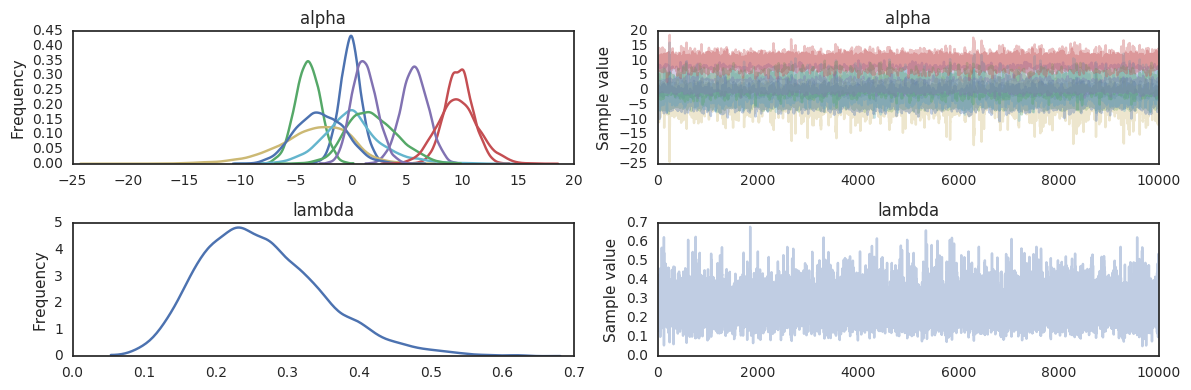

In [175]:
traceplot(trace)

In [176]:
G = X.T.dot(X)

In [177]:
ts = X.dot(trace['alpha'].T)
ts_tilde = ts.T - np.mean(ts, axis=1)

In [178]:
alpha = trace['alpha'] - np.mean(trace['alpha'], axis=0)

In [179]:
covs = alpha.T.dot(ts_tilde) / 10000

In [180]:
stds_freq = np.sqrt(covs.T.dot(G).dot(covs).diagonal())

In [181]:
stds_bay = np.std(ts,axis=1)

(array([   1.,    3.,    3.,    1.,   17.,   59.,  108.,  144.,   89.,   17.]),
 array([ 0.83021629,  0.84880483,  0.86739338,  0.88598193,  0.90457047,
         0.92315902,  0.94174756,  0.96033611,  0.97892465,  0.9975132 ,
         1.01610174]),
 <a list of 10 Patch objects>)

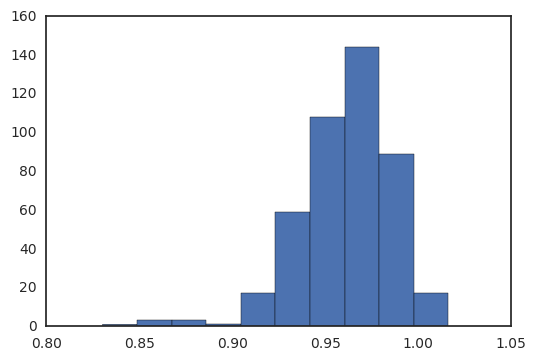

In [182]:
plt.hist(stds_freq/stds_bay)

In [183]:
stds_bay[124]

0.074273542491352082

In [184]:
stds_freq[124]

0.074528166983697547

In [185]:
y_hat = np.mean(ts, axis=1)
np.sum(np.square(y_hat - y))

433.46190710084727

## Neural network model

From the PyMC3 documentation.

In [40]:
%matplotlib inline
import theano
floatX = theano.config.floatX
import pymc3 as pm
import theano.tensor as T
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons

In [41]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X = X.astype(floatX)
Y = Y.astype(floatX)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

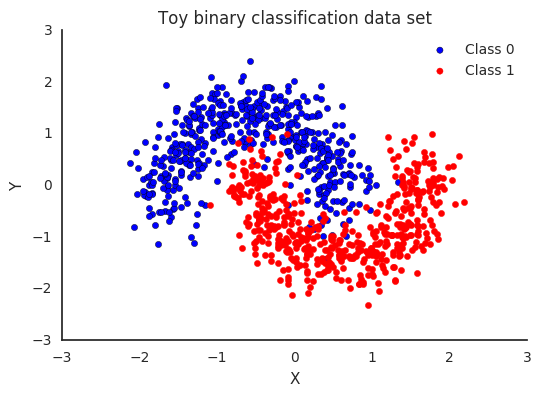

In [42]:
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='Toy binary classification data set');

In [61]:
ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

n_hidden = 10

# Initialize random weights and biases between each layer
# hidden layer
init_wh = np.random.randn(X.shape[1], n_hidden).astype(floatX)
init_bh = np.random.randn(n_hidden).astype(floatX)
# output layer
init_wo = np.random.randn(n_hidden).astype(floatX)
init_bo = np.random.randn()

with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_ih = pm.Normal('w_ih', 0, sd=1,
                            shape=(X.shape[1], n_hidden),
                            testval=init_wh)
    # Biases from input to hidden layer
    biases_ih = pm.Normal('b_ih', 0, sd=1,
                            shape=n_hidden,
                            testval=init_bh)

    # Weights from hidden layer to output
    weights_ho = pm.Normal('w_ho', 0, sd=1,
                            shape=(n_hidden,),
                            testval=init_wo)
    biases_ho = pm.Normal('b_ho', 0, sd=1,
                            testval=init_bo)

    # Build neural-network using tanh activation function
    act_hid = pm.math.tanh(biases_ih + \
                           pm.math.dot(ann_input,weights_ih))
    act_out = pm.math.sigmoid(biases_ho + \
                              pm.math.dot(act_hid, weights_ho))

    # Binary classification -> Bernoulli likelihood
    out = pm.Bernoulli('out',
                       act_out,
                       observed=ann_output)

In [62]:
%%time

with neural_network:
    # Run ADVI which returns posterior means, standard deviations, and the evidence lower bound (ELBO)
    v_params = pm.variational.advi(n=50000)

Average ELBO = -142.57: 100%|██████████| 50000/50000 [00:23<00:00, 2160.98it/s]
Finished [100%]: Average ELBO = -137.26


CPU times: user 25.3 s, sys: 452 ms, total: 25.7 s
Wall time: 25 s


In [63]:
%%time

with neural_network:
    trace = pm.variational.sample_vp(v_params, draws=5000)

100%|██████████| 5000/5000 [00:00<00:00, 7609.14it/s]

CPU times: user 1.4 s, sys: 32 ms, total: 1.43 s
Wall time: 1.41 s


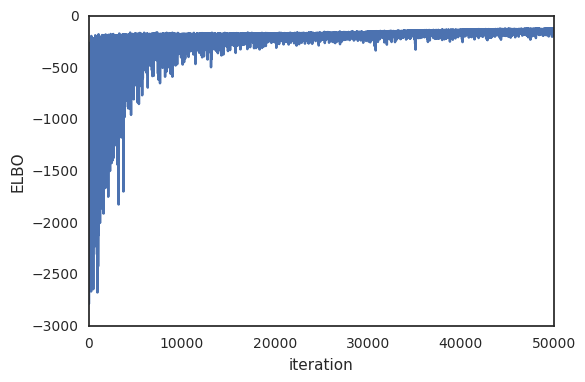

In [64]:
plt.plot(v_params.elbo_vals)
plt.ylabel('ELBO')
plt.xlabel('iteration');

In [65]:
# Replace shared variables with testing set
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

# Use probability of > 0.5 to assume prediction of class 1
pred = ppc['out'].mean(axis=0) > 0.5

100%|██████████| 500/500 [00:03<00:00, 129.39it/s]


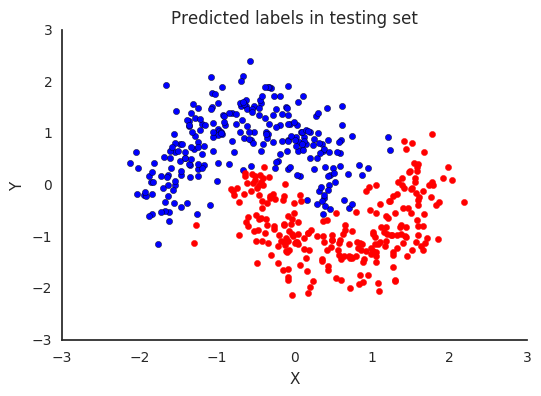

In [66]:
fig, ax = plt.subplots()
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
sns.despine()
ax.set(title='Predicted labels in testing set', xlabel='X', ylabel='Y');

In [67]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 94.8%


In [68]:
grid = np.mgrid[-3:3:100j,-3:3:100j].astype(floatX)
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [127]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network)

100%|██████████| 5000/5000 [01:11<00:00, 70.39it/s]


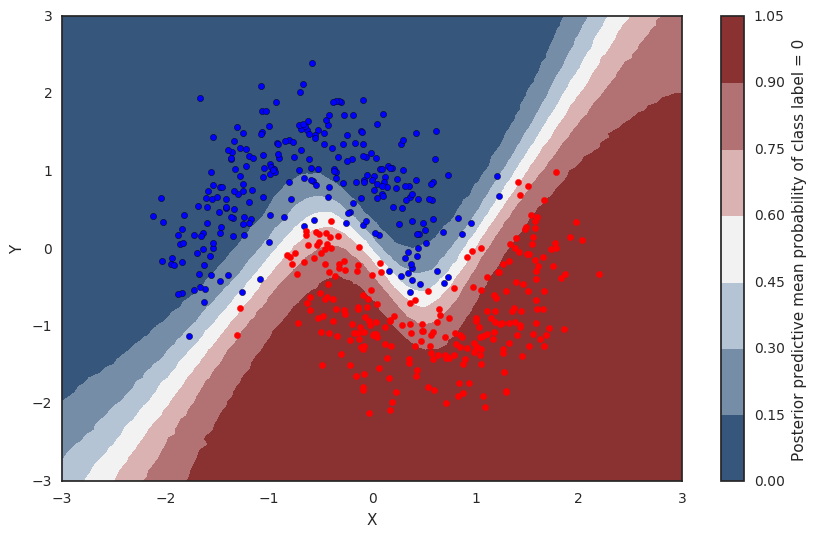

In [128]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 0');

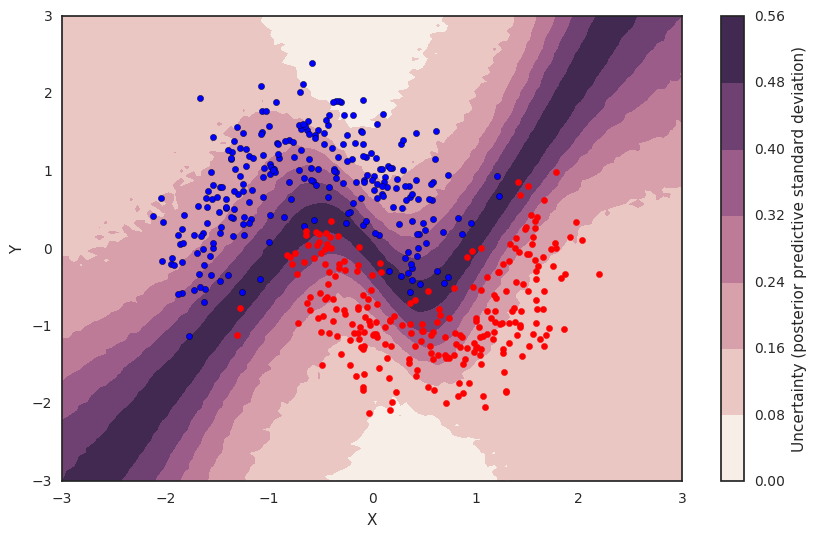

In [129]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(10, 6))
contour = ax.contourf(*grid, ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3), xlabel='X', ylabel='Y');
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)');

Goal now would be to compare the predictive Bayesian standard deviation to the frequentist standard deviation (obtained from the general accuracy formula). However, we did not manage to extract a sufficient statistic wrt our model parameters.

***
## Automatic Relevance Determination

The prior suggested by 

In [130]:
ts = ppc['out']
ts_tilde = ts - ppc['out'].mean(axis=0)

In [131]:
trace.varnames

['w_ih', 'b_ih', 'w_ho', 'b_ho']

In [132]:
wh = trace['w_ih']
bh = trace['b_ih']
wo = trace['w_ho']
bo = trace['b_ho']

In [133]:
wh[0]

array([[-1.45556858, -0.61785144,  3.49821356,  1.00182015, -2.15948718,
        -0.36976464,  1.86379418, -0.73833753, -1.51331166, -0.38401159],
       [ 0.78543049,  1.31288346,  1.42626704,  2.71933327,  0.88893069,
         1.74865023,  0.55487668, -1.27051766, -0.10741909, -1.58811089]])

In [101]:
wh.reshape((500,20))[0]

array([-1.45556858, -0.61785144,  3.49821356,  1.00182015, -2.15948718,
       -0.36976464,  1.86379418, -0.73833753, -1.51331166, -0.38401159,
        0.78543049,  1.31288346,  1.42626704,  2.71933327,  0.88893069,
        1.74865023,  0.55487668, -1.27051766, -0.10741909, -1.58811089])

In [102]:
bh.shape

(500, 10)

In [103]:
wo.shape

(500, 10)

In [104]:
bo.shape

(500,)

In [134]:
flat_wh = wh.reshape((5000,20))
vect_bo = bo.reshape((5000,1))
alpha = np.hstack((flat_wh, bh, wo, vect_bo))

In [135]:
alpha.shape

(5000, 41)

In [136]:
ts_tilde.shape

(5000, 10000)

In [137]:
covs = alpha.T.dot(ts_tilde) / 5000

In [121]:
grid_2d.shape

(10000, 2)

In [138]:
G = grid_2d.dot(grid_2d.T)

In [139]:
stds_freq = np.sqrt(covs.T.dot(G).dot(covs).diagonal())

ValueError: shapes (10000,41) and (10000,10000) not aligned: 41 (dim 1) != 10000 (dim 0)

In [119]:
stds_freq.shape

(41,)

__TODO__

+ Vérifier ces résultats pour confirmer l'utilisation de PyMC
+ Appliquer la _general accuracy formula_ et vérifier les valeurs obtenues
+ Essayer d'étendre à une application plus difficile (_hierarchical Bayes_, _Bayesian learning for neural networks_...)

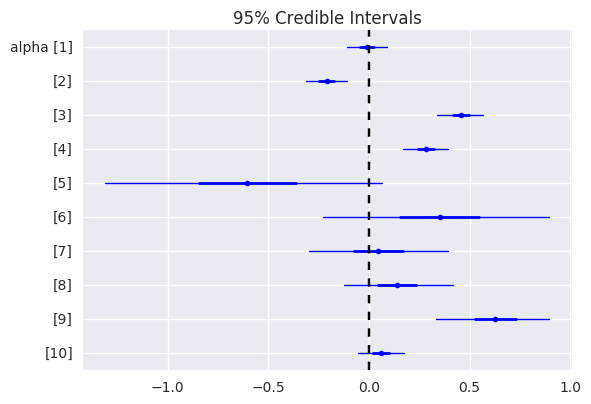

In [136]:
from pymc3 import forestplot

forestplot(trace);

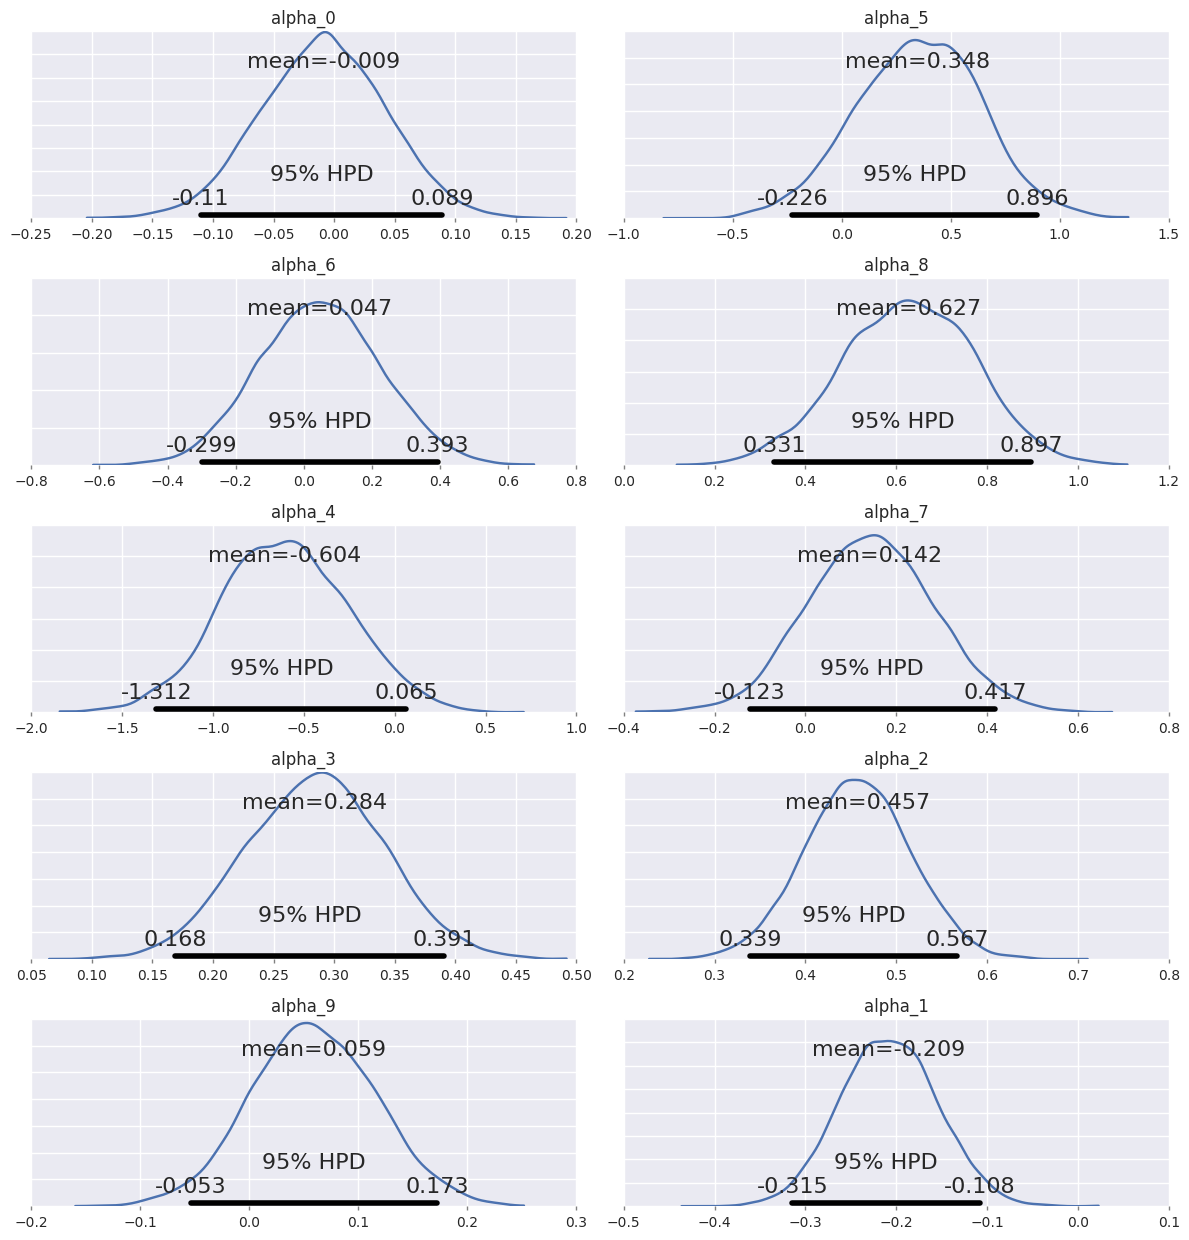

In [137]:
from pymc3 import plot_posterior

plot_posterior(trace, kde_plot=True);